In [296]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn import metrics

import wandb
from wandb.keras import WandbCallback

#custom packages
from config import setup_wandb_dedicated, setup_wandb_parametrized
from models import MyModel, createSimpleModel

In [206]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [41]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [61]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [62]:
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [63]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [64]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

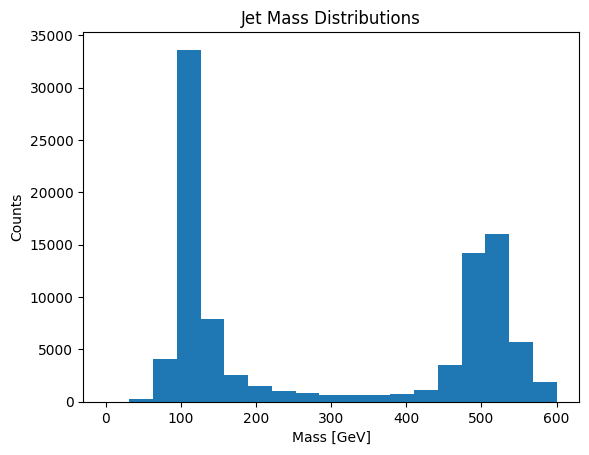

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [10]:
file = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq.txt")

jets = []
count = 0
for line in file:
    if count == 2:
        break
    print(line)
    jets += [line.split("J")[1].split("P")[0].split()]
    count+=1

0 0 J 1788.55 -0.300279 -2.51608 130.279 0 0.0289343 0.0153102 0.0126833 0.010346 0.00825964  P 4.64413 -0.377384 3.00207  P 2.47947 -0.425799 3.02334  P 2.68613 -0.39458 -2.608  P 5.84707 -0.404504 -2.54133  P 24.9416 -0.408844 -2.52053  P 6.58412 -0.387347 -2.54543  P 13.1517 -0.350432 -2.59254  P 13.7381 -0.300859 -2.52212  P 4.55674 -0.286343 -2.52545  P 517.142 -0.286492 -2.50205 

0 1 J 1643.32 -0.173344 0.717105 95.8961 0 0.0424313 0.0221081 0.0140335 0.0108518 0.00877299  P 1.75001 -0.530883 0.585762  P 2.74298 -0.297844 0.694373  P 5.4756 -0.195946 0.630677  P 7.35714 -0.200437 0.647468  P 9.16487 -0.119969 0.704896  P 5.77878 -0.125155 0.709119  P 6.37682 -0.141306 0.773328  P 8.23397 -0.155549 0.732862  P 29.6409 -0.186092 0.763671  P 2.24246 -0.170876 0.729569  P 245.519 -0.180535 0.735561 



In [56]:
jets

[['1788.55',
  '-0.300279',
  '-2.51608',
  '130.279',
  '0',
  '0.0289343',
  '0.0153102',
  '0.0126833',
  '0.010346',
  '0.00825964'],
 ['1643.32',
  '-0.173344',
  '0.717105',
  '95.8961',
  '0',
  '0.0424313',
  '0.0221081',
  '0.0140335',
  '0.0108518',
  '0.00877299']]

In [31]:
ljet = [jets[2*n] for n in range(int(len(jets)/2))]
sjet = [jets[2*n+1] for n in range(int(len(jets)/2))]

In [32]:
ljet

[['1788.55',
  '-0.300279',
  '-2.51608',
  '130.279',
  '0',
  '0.0289343',
  '0.0153102',
  '0.0126833',
  '0.010346',
  '0.00825964']]

In [11]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [12]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [13]:
m = 100
file = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(m)+"_"+str(m)+".txt")
jets_m_m = []
for line in file:
    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
    pass
computemjj_txt(jets_m_m)[0]

3674.182176987098

In [44]:
len(jets_m_m)

180286

In [42]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array", x_array)

In [813]:
#reads in data 
x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [913]:
np.shape(x[0,0])

(75955, 4)

In [932]:
x = {}
x_array_read = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [411]:
class MyModel1(Model):
    def __init__(self):
        super(MyModel1, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation=config.activation_2)
        
        self.dense3 = Dense(config.layer_3, activation=config.activation_3)
        
        self.dense4 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        
        x = self.dense3(x)
        
        x = self.dense4(x)
        
        return x

In [412]:
#if not wandb.run:
    #initializies wandb config
wandb.init(
    project="Anomaly",
    group="Dedicated",
    entity='gup-singh',
    mode = 'disabled',

    config={
        "layer_1": 512,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 512,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "MeanSquaredError",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 1024
    }
)

config = wandb.config

In [382]:
x_vals_100 = np.concatenate([x[0,0],x[1,1]])
y_vals_100 = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_vals_100, y_vals_100, test_size=0.5)

model = MyModel1()
model.build(input_shape=(None, X_train_100.shape[1]))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=config.optimizer, metrics=["accuracy"])
model.summary()

Model: "my_model1_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_827 (Dense)           multiple                  2560      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
 dense_828 (Dense)           multiple                  262656    
                                                                 
 dense_829 (Dense)           multiple                  65664     
                                                                 
 dense_830 (Dense)           multiple                  129       
                                                                 
Total params: 331,009
Trainable params: 331,009
Non-trainable params: 0
_________________________________________________________________


In [383]:
myhistory = model.fit(x_vals_100, y_vals_100, epochs=config.epoch, validation_data=(X_val_100, Y_val_100),batch_size=config.batch_size, callbacks=[WandbCallback()])

Epoch 1/20
184/193 [===========================>..] - ETA: 0s - loss: 0.2578 - accuracy: 0.8942

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.2552 - accuracy: 0.8954 - val_loss: 0.1934 - val_accuracy: 0.9212
Epoch 2/20
184/193 [===========================>..] - ETA: 0s - loss: 0.1912 - accuracy: 0.9239

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1911 - accuracy: 0.9240 - val_loss: 0.1814 - val_accuracy: 0.9268
Epoch 3/20
174/193 [==========================>...] - ETA: 0s - loss: 0.1854 - accuracy: 0.9261

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1854 - accuracy: 0.9260 - val_loss: 0.1794 - val_accuracy: 0.9273
Epoch 4/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1833 - accuracy: 0.9268 - val_loss: 0.1800 - val_accuracy: 0.9270
Epoch 5/20
178/193 [==========================>...] - ETA: 0s - loss: 0.1824 - accuracy: 0.9266

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1825 - accuracy: 0.9264 - val_loss: 0.1785 - val_accuracy: 0.9277
Epoch 6/20
186/193 [===========================>..] - ETA: 0s - loss: 0.1816 - accuracy: 0.9269

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1814 - accuracy: 0.9270 - val_loss: 0.1765 - val_accuracy: 0.9281
Epoch 7/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9275 - val_loss: 0.1768 - val_accuracy: 0.9281
Epoch 8/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1799 - accuracy: 0.9274 - val_loss: 0.1782 - val_accuracy: 0.9273
Epoch 9/20
167/193 [========================>.....] - ETA: 0s - loss: 0.1813 - accuracy: 0.9275

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1806 - accuracy: 0.9278 - val_loss: 0.1762 - val_accuracy: 0.9282
Epoch 10/20
165/193 [========================>.....] - ETA: 0s - loss: 0.1799 - accuracy: 0.9279

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


193/193 [==============================] - 11s 59ms/step - loss: 0.1798 - accuracy: 0.9277 - val_loss: 0.1761 - val_accuracy: 0.9287
Epoch 11/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9277 - val_loss: 0.1781 - val_accuracy: 0.9273
Epoch 12/20
166/193 [========================>.....] - ETA: 0s - loss: 0.1788 - accuracy: 0.9281

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1792 - accuracy: 0.9279 - val_loss: 0.1753 - val_accuracy: 0.9284
Epoch 13/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1785 - accuracy: 0.9279 - val_loss: 0.1772 - val_accuracy: 0.9284
Epoch 14/20
170/193 [=========================>....] - ETA: 0s - loss: 0.1789 - accuracy: 0.9282

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1785 - accuracy: 0.9284 - val_loss: 0.1743 - val_accuracy: 0.9285
Epoch 15/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1788 - accuracy: 0.9281 - val_loss: 0.1760 - val_accuracy: 0.9282
Epoch 16/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1782 - accuracy: 0.9283 - val_loss: 0.1756 - val_accuracy: 0.9288
Epoch 17/20
176/193 [==========================>...] - ETA: 0s - loss: 0.1781 - accuracy: 0.9285

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231012_123720-265qgk2f/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 6ms/step - loss: 0.1778 - accuracy: 0.9285 - val_loss: 0.1739 - val_accuracy: 0.9290
Epoch 18/20
193/193 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.9287 - val_loss: 0.1740 - val_accuracy: 0.9292
Epoch 19/20
193/193 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.9287 - val_loss: 0.1773 - val_accuracy: 0.9278
Epoch 20/20
193/193 [==============================] - 0s 3ms/step - loss: 0.1772 - accuracy: 0.9289 - val_loss: 0.1744 - val_accuracy: 0.9289


In [384]:
wandb.finish()

accuracy,▁▇▇█▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▆▇▇▇▆▇█▆▇▇▇▇███▇█
val_loss,█▄▃▃▃▂▂▃▂▂▂▁▂▁▂▂▁▁▂▁
accuracy,0.92885
best_epoch,16
best_val_loss,0.17393
epoch,19
loss,0.1772
val_accuracy,0.92891


In [385]:
#model.save("model_BCE")
#model.save("model_MSE")

INFO:tensorflow:Assets written to: model_BCE/assets


In [386]:
model_BCE = tf.keras.models.load_model('model_BCE')
model_MSE = tf.keras.models.load_model('model_MSE')

In [415]:
preds_mm_list = []
fpr_mm_list = []
tpr_mm_list = []

for i in mass_range[1:]:
    for j in mass_range[1:]:
        x_vals_mm = np.concatenate([x[0,0],x[i,j]])
        y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
        X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)
        
        modelmm = MyModel1()
        modelmm.build(input_shape=(None, X_train_mm.shape[1]))
        modelmm.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=config.optimizer, metrics=["accuracy"])
        myhistory_mm = model.fit(x_vals_mm, y_vals_mm, epochs=config.epoch, validation_data=(X_val_mm, Y_val_mm),batch_size=config.batch_size, callbacks=[WandbCallback()])
        
        preds_mm = model.predict(X_val_mm,batch_size=1000)
        fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)
        
        preds_mm_list.append(preds_mm)
        fpr_mm_list.append(fpr_mm)
        tpr_mm_list.append(tpr_mm)

Epoch 1/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.8941 - val_loss: 0.2490 - val_accuracy: 0.8959
Epoch 2/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.8934 - val_loss: 0.2491 - val_accuracy: 0.8956
Epoch 3/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2539 - accuracy: 0.8932 - val_loss: 0.2489 - val_accuracy: 0.8959
Epoch 4/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2538 - accuracy: 0.8932 - val_loss: 0.2498 - val_accuracy: 0.8953
Epoch 5/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.8938 - val_loss: 0.2498 - val_accuracy: 0.8954
Epoch 6/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.8936 - val_loss: 0.2500 - val_accuracy: 0.8956
Epoch 7/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2535 - accuracy: 0.8933 - val_loss: 0.2488 - val_accuracy: 0.8957
Epoch 

In [8]:
# np.save("fpr_mm", fpr_mm_list)
# np.save("tpr_mm", tpr_mm_list)
#np.save("tuple_mass_index", tuple_mass_index)

tpr_mm_list = np.load("tpr_mm.npy", allow_pickle = True)
fpr_mm_list = np.load("fpr_mm.npy", allow_pickle = True)

In [170]:
tuple_mass_index = np.load("tuple_mass_index.npy", allow_pickle = True).item()

In [189]:
len(tuple_mass_index)

144

/tmp/ipykernel_1625481/1560960496.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_mm_list[i], 1./fpr_mm_list[i])
/tmp/ipykernel_1625481/1560960496.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all,1./fpr_all,label="parameterized")


Text(0.5, 1.0, '$(m_{B},m_{C})$ 50 $\\Rightarrow$ 600 GeV Dedicated vs Parametrized')

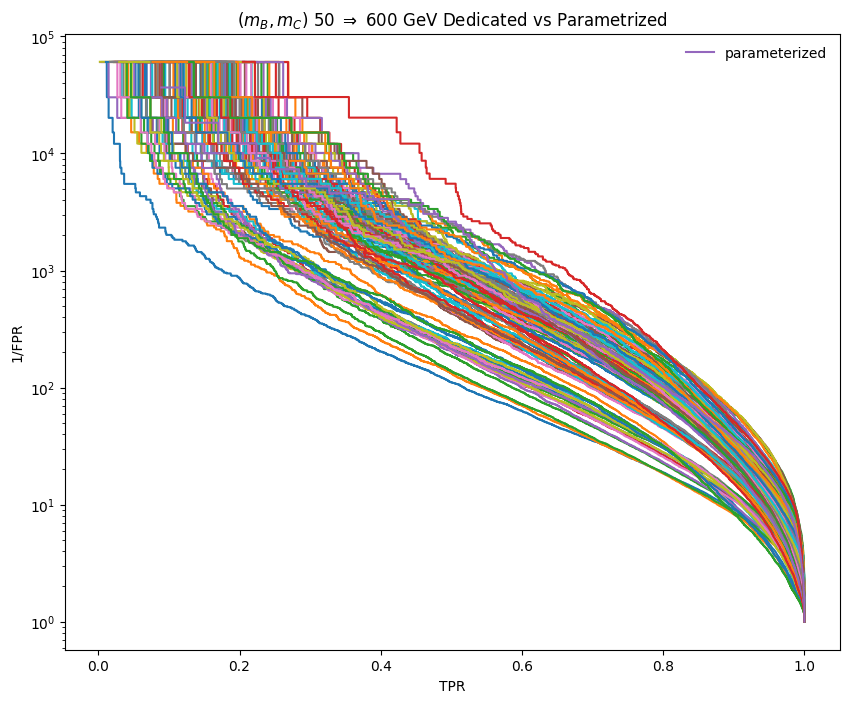

In [17]:
plt.figure(figsize=(10,8))
for i in range(len(tpr_mm_list)):
    plt.plot(tpr_mm_list[i], 1./fpr_mm_list[i])
plt.plot(tpr_all,1./fpr_all,label="parameterized")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{B},m_{C})$ 50 $\Rightarrow$ 600 GeV Dedicated vs Parametrized")

In [205]:
len(tuple_mass_index[(0.5, 0.5)][0])

17319

In [460]:
preds_all_50 = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[.5,.5],axis=1)==1],batch_size=1000)
fpr_all_50, tpr_all_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[.5,.5],axis=1)==1], preds_all_50)

preds_all_200 = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[2.,2.],axis=1)==1],batch_size=1000)
fpr_all_200, tpr_all_200, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[2.,2.],axis=1)==1], preds_all_200)

preds_all_400 = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[4.,4.],axis=1)==1],batch_size=1000)
fpr_all_400, tpr_all_400, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4.,4.],axis=1)==1], preds_all_400)

preds_all_600 = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[6.,6.],axis=1)==1],batch_size=1000)
fpr_all_600, tpr_all_600, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[6.,6.],axis=1)==1], preds_all_600)

87/87 [==============================] - 0s 622us/step


Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized')

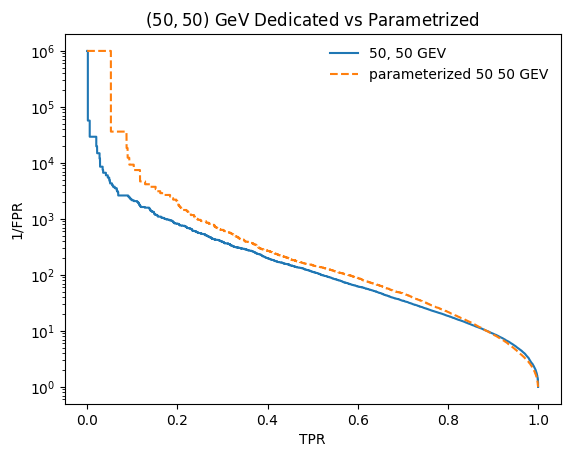

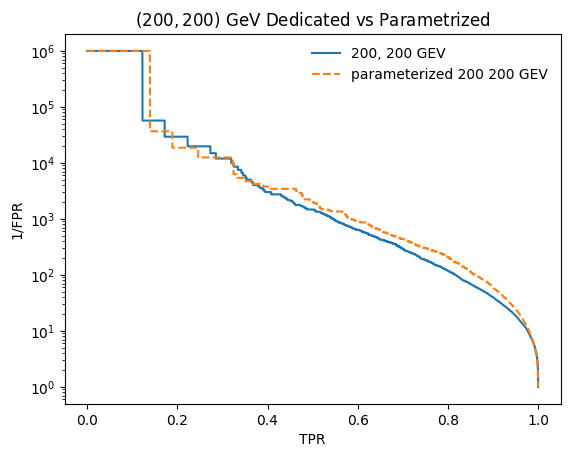

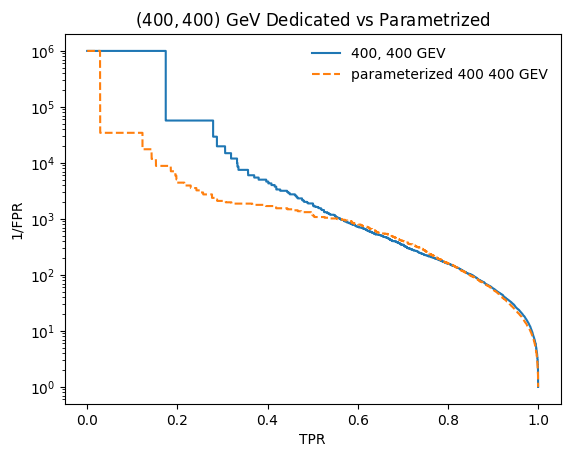

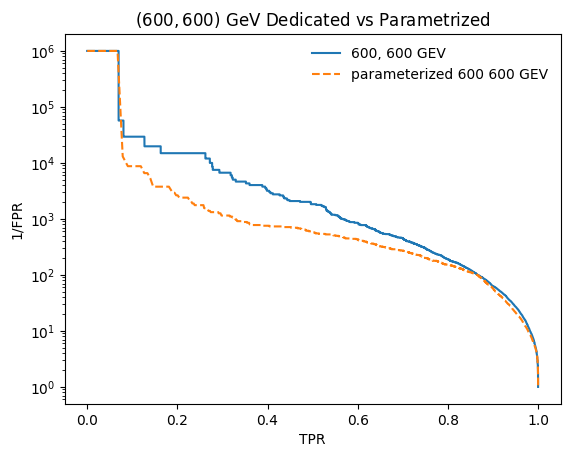

In [461]:
epsilon = 1e-6
plt.figure()
plt.plot(tpr_mm_list[0], 1./(fpr_mm_list[0] + epsilon), label = "50, 50 GEV")
plt.plot(tpr_all_50, 1./(fpr_all_50 + epsilon),label="parameterized 50 50 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(50,50)$ GeV Dedicated vs Parametrized")

plt.figure()
plt.plot(tpr_mm_list[26], 1./(fpr_mm_list[26] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_all_200, 1./(fpr_all_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(200, 200)$ GeV Dedicated vs Parametrized")

plt.figure()
plt.plot(tpr_mm_list[52], 1./(fpr_mm_list[52] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_all_400, 1./(fpr_all_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(400, 400)$ GeV Dedicated vs Parametrized")

plt.figure()
plt.plot(tpr_mm_list[78], 1./(fpr_mm_list[78] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_600, 1./(fpr_all_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized")

Text(0.5, 1.0, '$(m_{A},m_{B})$ GeV Dedicated vs Parametrized using MSE')

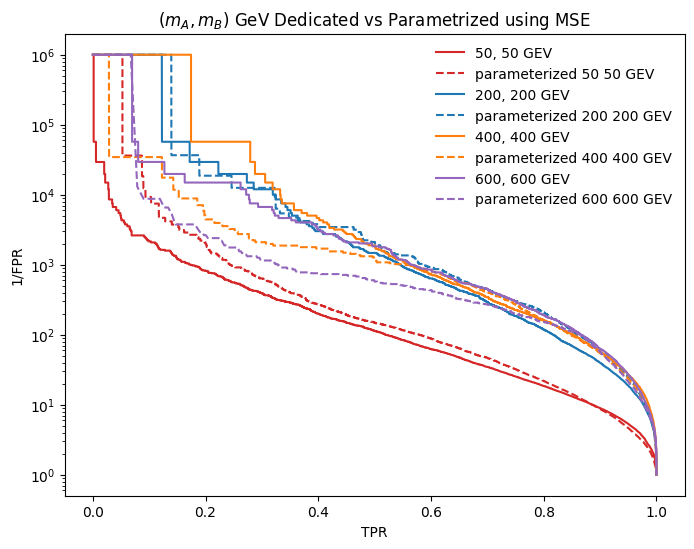

In [462]:
plt.figure(figsize = (8, 6))
epsilon = 1e-6
plt.plot(tpr_mm_list[0], 1./(fpr_mm_list[0] + epsilon), label = "50, 50 GEV", color = "#d62728")
plt.plot(tpr_all_50, 1./(fpr_all_50 + epsilon),label="parameterized 50 50 GEV", linestyle='dashed', color = "#d62728")

plt.plot(tpr_mm_list[26], 1./(fpr_mm_list[26] + epsilon), label = "200, 200 GEV", color = "#1f77b4")
plt.plot(tpr_all_200, 1./(fpr_all_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed', color = "#1f77b4")

plt.plot(tpr_mm_list[52], 1./(fpr_mm_list[52] + epsilon), label = "400, 400 GEV", color = "#ff7f0e")
plt.plot(tpr_all_400, 1./(fpr_all_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed', color = "#ff7f0e")

plt.plot(tpr_mm_list[78], 1./(fpr_mm_list[78] + epsilon), label = "600, 600 GEV", color = "#9467bd")
plt.plot(tpr_all_600, 1./(fpr_all_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed', color = "#9467bd")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{A},m_{B})$ GeV Dedicated vs Parametrized using MSE")

In [78]:
# plt.plot(tpr_mm_list[0],1./fpr_mm_list[0],label="dedicated_100")
# plt.plot(tpr_all_100,1./fpr_all_100,label="parameterized")
# plt.yscale("log")
# plt.legend(frameon=False)
# plt.xlabel("TPR")
# plt.ylabel("1/FPR")
# plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated vs Parametrized")

Text(0.5, 1.0, '$(m_{B},m_{C})$ GeV Dedicated vs Parametrized')

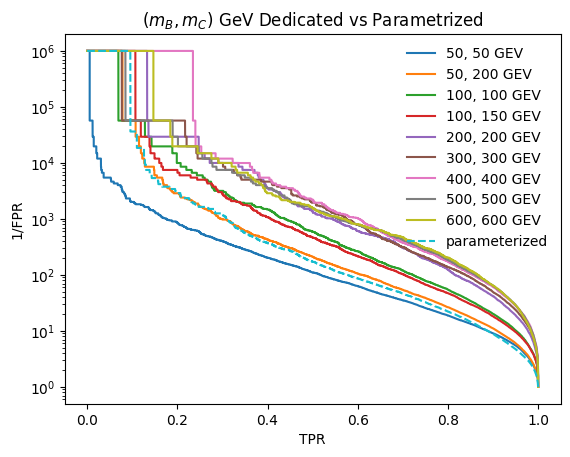

In [363]:
epsilon = 1e-6
plt.plot(tpr_mm_list[0], 1./(fpr_mm_list[0] + epsilon), label = "50, 50 GEV")
#plt.plot(tpr_mm_list[1], 1./(fpr_mm_list[1] + epsilon), label = "50, 100 GEV")
plt.plot(tpr_mm_list[3], 1./(fpr_mm_list[3] + epsilon), label = "50, 200 GEV")
plt.plot(tpr_mm_list[13], 1./(fpr_mm_list[13] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_mm_list[14], 1./(fpr_mm_list[14] + epsilon), label = "100, 150 GEV")
plt.plot(tpr_mm_list[26], 1./(fpr_mm_list[26] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_mm_list[39], 1./(fpr_mm_list[39] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_mm_list[52], 1./(fpr_mm_list[52] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_mm_list[65], 1./(fpr_mm_list[65] + epsilon), label = "500, 500 GEV")
plt.plot(tpr_mm_list[78], 1./(fpr_mm_list[78] + epsilon), label = "600, 600 GEV")

plt.plot(tpr_all, 1./(fpr_all + epsilon),label="parameterized", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{B},m_{C})$ GeV Dedicated vs Parametrized")

Analysis of Models begins here

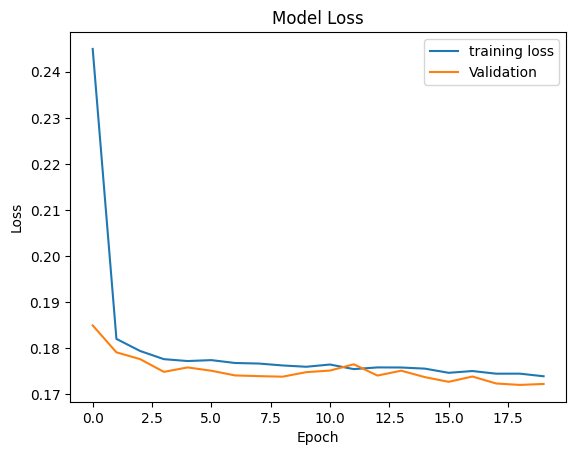

In [255]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [89]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = metrics.roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 737us/step


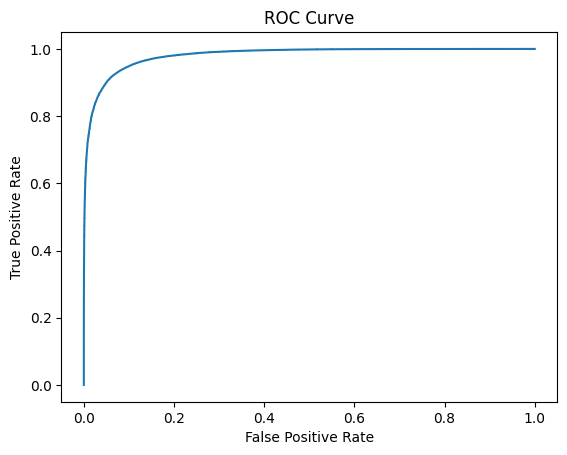

In [79]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [833]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    np.save("x_vals_all",x_vals_all)
    np.save("y_vals_all",y_vals_all)

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [920]:
x_vals_qq = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/x_vals_qq.npy")
y_vals_qq = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/y_vals_qq.npy")

In [921]:
np.shape(x_vals_qq)

(27188652, 8)

In [922]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_vals_qq, y_vals_qq, test_size=0.5)

In [827]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [834]:
np.shape(x_vals_all)

(27188652, 6)

In [835]:
x_vals_all

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319,  0.5       ,
         0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092,  0.5       ,
         0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752,  0.5       ,
         0.5       ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [918]:
x_vals_qq[:,0:8]

array([[-1.08511704, -0.13951411,  0.29623825, ...,  0.66468713,
         0.5       ,  0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, ..., -0.0247789 ,
         0.5       ,  0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, ..., -1.97102352,
         0.5       ,  0.5       ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, ..., -3.0136306 ,
         6.        ,  6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, ...,  0.27557877,
         6.        ,  6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, ...,  0.56379867,
         6.        ,  6.        ]])

In [854]:
np.array_equal(x_vals_all, test_x_vals_)

True

In [853]:
test_x_vals_

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319,  0.5       ,
         0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092,  0.5       ,
         0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752,  0.5       ,
         0.5       ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [836]:
y_vals_all

array([0., 0., 0., ..., 1., 1., 1.])

In [855]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [803]:
Y_val_all

array([0., 0., 0., ..., 1., 0., 0.])

In [797]:
#config2 = setup_wandb_parametrized();
class MyModel2(Model):
    def __init__(self):
        super(MyModel2, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation=config.activation_2)
        
        self.dense3 = Dense(config.layer_3, activation=config.activation_3)
        
        self.dense4 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        
        x = self.dense3(x)
        
        x = self.dense4(x)
        
        return x

In [798]:
wandb.init(
    project="Anomaly",
    group="Parametrized",
    entity='gup-singh',
    mode = 'disabled',

    config={
        "layer_1": 1024,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 512,
        "activation_2": "relu",
        "layer_3": 256,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "MeanSquaredError",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 1024
    }
)

config = wandb.config

In [856]:
# model_all.build(input_shape=(None, X_train_all.shape[1]))
# model_all.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=config2.optimizer, metrics=["accuracy"])
# model_all.summary()

In [925]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [928]:
model_qq = Sequential()
model_qq.add(Dense(256, input_dim=8, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_qq.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_qq = model_qq.fit(x_vals_qq, y_vals_qq, epochs=20,validation_data=(X_val_qq, Y_val_qq),batch_size=5*1024)

Epoch 1/20
5311/5311 [==============================] - 19s 3ms/step - loss: 0.2248 - accuracy: 0.9128 - val_loss: 0.1820 - val_accuracy: 0.9305
Epoch 2/20
5311/5311 [==============================] - 17s 3ms/step - loss: 0.1710 - accuracy: 0.9340 - val_loss: 0.1621 - val_accuracy: 0.9372
Epoch 3/20
5311/5311 [==============================] - 18s 3ms/step - loss: 0.1577 - accuracy: 0.9389 - val_loss: 0.1534 - val_accuracy: 0.9407
Epoch 4/20
5311/5311 [==============================] - 16s 3ms/step - loss: 0.1511 - accuracy: 0.9416 - val_loss: 0.1485 - val_accuracy: 0.9426
Epoch 5/20
5311/5311 [==============================] - 17s 3ms/step - loss: 0.1471 - accuracy: 0.9432 - val_loss: 0.1451 - val_accuracy: 0.9439
Epoch 6/20
5311/5311 [==============================] - 17s 3ms/step - loss: 0.1443 - accuracy: 0.9443 - val_loss: 0.1428 - val_accuracy: 0.9448
Epoch 7/20
5311/5311 [==============================] - 17s 3ms/step - loss: 0.1422 - accuracy: 0.9450 - val_loss: 0.1410 - val_ac

In [929]:
model_qq.save('model_qq_v2')

INFO:tensorflow:Assets written to: model_qq_v2/assets


In [ ]:
model_qq = tf.keras.models.load_model('model_qq')

In [ ]:
model_all = Sequential()
model_all.add(Dense(128, input_dim=6, activation='relu'))
model_all.add(Dense(128, activation='relu'))
model_all.add(Dense(128, activation='relu'))
model_all.add(Dense(1, activation='sigmoid'))
model_all.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [857]:
myhistory_all = model_all.fit(x_vals_all, y_vals_all, epochs=20,validation_data=(X_val_all, Y_val_all),batch_size=1024*5)

Epoch 1/20
5311/5311 [==============================] - 13s 2ms/step - loss: 0.1749 - accuracy: 0.9312 - val_loss: 0.1630 - val_accuracy: 0.9362
Epoch 2/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.1630 - accuracy: 0.9361 - val_loss: 0.1619 - val_accuracy: 0.9365
Epoch 3/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.1621 - accuracy: 0.9364 - val_loss: 0.1614 - val_accuracy: 0.9367
Epoch 4/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.1616 - accuracy: 0.9366 - val_loss: 0.1615 - val_accuracy: 0.9367
Epoch 5/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1614 - accuracy: 0.9367 - val_loss: 0.1611 - val_accuracy: 0.9368
Epoch 6/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.1611 - accuracy: 0.9368 - val_loss: 0.1608 - val_accuracy: 0.9370
Epoch 7/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1610 - accuracy: 0.9368 - val_loss: 0.1610 - val_ac

In [788]:
with tf.device('/gpu:0'):
    myhistory_all = model_all.fit(x_vals_all, y_vals_all, epochs=config2.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config2.batch_size*5, callbacks = [WandbCallback()])

Epoch 1/20
5307/5311 [============================>.] - ETA: 0s - loss: 0.1451 - accuracy: 0.9436

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 17s 3ms/step - loss: 0.1451 - accuracy: 0.9436 - val_loss: 0.1317 - val_accuracy: 0.9491
Epoch 2/20
5296/5311 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9475

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.3s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1356 - accuracy: 0.9475 - val_loss: 0.1311 - val_accuracy: 0.9493
Epoch 3/20
5301/5311 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9481

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1342 - accuracy: 0.9481 - val_loss: 0.1299 - val_accuracy: 0.9497
Epoch 4/20
5287/5311 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9484

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1334 - accuracy: 0.9484 - val_loss: 0.1295 - val_accuracy: 0.9499
Epoch 5/20
5308/5311 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.9486

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1329 - accuracy: 0.9486 - val_loss: 0.1292 - val_accuracy: 0.9500
Epoch 6/20
5307/5311 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9487

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1324 - accuracy: 0.9487 - val_loss: 0.1287 - val_accuracy: 0.9502
Epoch 7/20
5298/5311 [============================>.] - ETA: 0s - loss: 0.1321 - accuracy: 0.9489

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1321 - accuracy: 0.9489 - val_loss: 0.1286 - val_accuracy: 0.9502
Epoch 8/20
5290/5311 [============================>.] - ETA: 0s - loss: 0.1318 - accuracy: 0.9490

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1318 - accuracy: 0.9490 - val_loss: 0.1284 - val_accuracy: 0.9503
Epoch 9/20
5297/5311 [============================>.] - ETA: 0s - loss: 0.1316 - accuracy: 0.9491

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1316 - accuracy: 0.9491 - val_loss: 0.1281 - val_accuracy: 0.9504
Epoch 10/20
5311/5311 [==============================] - 13s 2ms/step - loss: 0.1313 - accuracy: 0.9492 - val_loss: 0.1282 - val_accuracy: 0.9504
Epoch 11/20
5311/5311 [==============================] - 13s 2ms/step - loss: 0.1311 - accuracy: 0.9493 - val_loss: 0.1282 - val_accuracy: 0.9504
Epoch 12/20
5295/5311 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9493

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1309 - accuracy: 0.9493 - val_loss: 0.1280 - val_accuracy: 0.9505
Epoch 13/20
5286/5311 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.9494

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1307 - accuracy: 0.9494 - val_loss: 0.1276 - val_accuracy: 0.9505
Epoch 14/20
5287/5311 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9495

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1305 - accuracy: 0.9495 - val_loss: 0.1273 - val_accuracy: 0.9507
Epoch 15/20
5311/5311 [==============================] - 13s 2ms/step - loss: 0.1303 - accuracy: 0.9496 - val_loss: 0.1274 - val_accuracy: 0.9506
Epoch 16/20
5307/5311 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9496

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1302 - accuracy: 0.9496 - val_loss: 0.1271 - val_accuracy: 0.9508
Epoch 17/20
5307/5311 [============================>.] - ETA: 0s - loss: 0.1300 - accuracy: 0.9497

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1300 - accuracy: 0.9497 - val_loss: 0.1269 - val_accuracy: 0.9508
Epoch 18/20
5301/5311 [============================>.] - ETA: 0s - loss: 0.1298 - accuracy: 0.9497

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1298 - accuracy: 0.9497 - val_loss: 0.1266 - val_accuracy: 0.9510
Epoch 19/20
5288/5311 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9498

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.1s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1297 - accuracy: 0.9498 - val_loss: 0.1264 - val_accuracy: 0.9510
Epoch 20/20
5308/5311 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.9498

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20231013_013944-2rwvwrvm/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 14s 3ms/step - loss: 0.1295 - accuracy: 0.9498 - val_loss: 0.1264 - val_accuracy: 0.9510


In [789]:
wandb.finish()

accuracy,▁▅▆▆▇▇▇▇▇▇▇▇████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇███
val_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
accuracy,0.94983
best_epoch,19
best_val_loss,0.12642
epoch,19
loss,0.12954
val_accuracy,0.95101


In [905]:
model_all.save("model_all_BCE")
#model_all.save("model_all_MSE")

INFO:tensorflow:Assets written to: model_all_BCE/assets


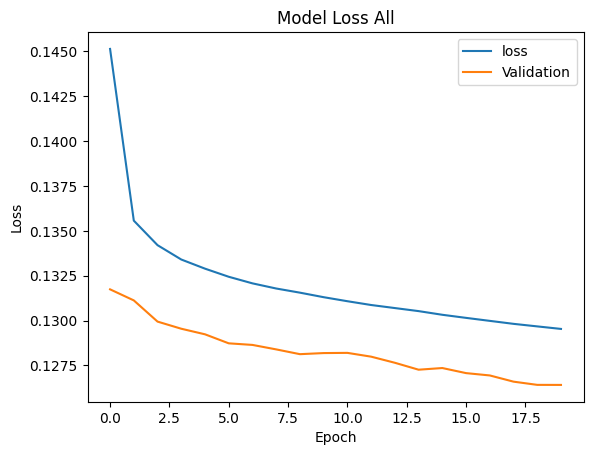

In [791]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [781]:
# preds_all_MSE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
# fpr_all_MSE, tpr_all_MSE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_MSE)

In [119]:
preds_all_BCE = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE, tpr_all_BCE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE)

99/99 [==============================] - 0s 859us/step


In [793]:
model_BCE = tf.keras.models.load_model('model_BCE')
model_MSE = tf.keras.models.load_model('model_MSE')

In [454]:
preds_100_BCE = model_BCE.predict(X_val_100,batch_size=1000)
fpr_100_BCE, tpr_100_BCE, _ = metrics.roc_curve(Y_val_100, preds_100_BCE)

preds_100_MSE = model_MSE.predict(X_val_100,batch_size=1000)
fpr_100_MSE, tpr_100_MSE, _ = metrics.roc_curve(Y_val_100, preds_100_MSE)

99/99 [==============================] - 0s 729us/step


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE')

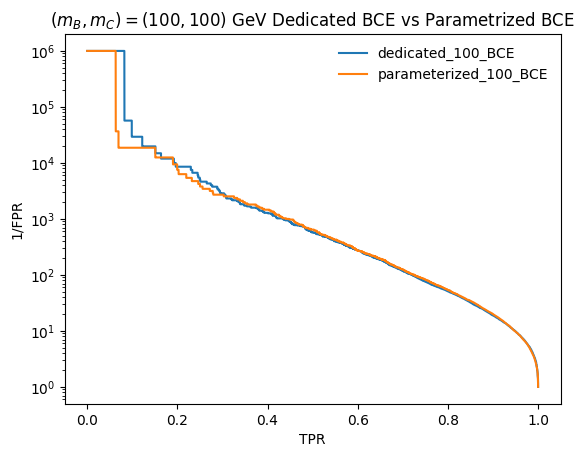

In [450]:
epsilon = 1e-6
plt.plot(tpr_100_BCE,1./(fpr_100_BCE + epsilon),label="dedicated_100_BCE")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE + epsilon),label="parameterized_100_BCE")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE")

Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated MSE vs Parametrized MSE')

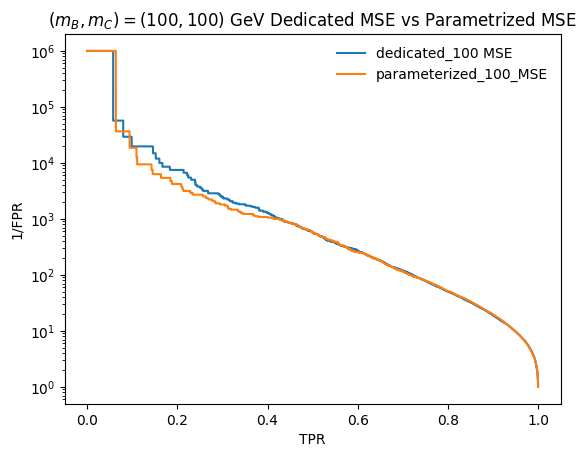

In [455]:
plt.plot(tpr_100_MSE,1./(fpr_100_MSE + epsilon),label="dedicated_100 MSE")
plt.plot(tpr_all_MSE,1./(fpr_all_MSE + epsilon),label="parameterized_100_MSE")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated MSE vs Parametrized MSE")

In [423]:
#freezes the layers of the model (i.e all trainable params)
for l in model_all.layers:
    l.trainable=False

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [82]:
model_all2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 tf.ones_like (TFOpLambda)      (None, 4)            0           ['input_3[0][0]']                
                                                                                                  
 tf.ones_like_1 (TFOpLambda)    (None, 4)            0           ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None,)             0           ['tf.ones_like[0][0]']           
 ingOpLambda)                                                                               

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [83]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 3.0335 - val_loss: 2.8581
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7964 - val_loss: 2.7314
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7099 - val_loss: 2.6704
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.6482 - val_loss: 2.6068
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5891 - val_loss: 2.5549
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5492 - val_loss: 2.5264
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5264 - val_loss: 2.5062
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5055 - val_loss: 2.4842
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4825 - val_loss: 2.4604
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4584 - val_loss: 2.4398

In [31]:
# class SingleWeightLayer(tf.keras.layers.Layer):
#     def __init__(self, initial_value=1, **kwargs):
#         super(SingleWeightLayer, self).__init__(**kwargs)
#         self.initial_value = initial_value
        
#     def build(self, input_shape):
#         self.weight = self.add_weight(shape=(1,), initializer=tf.keras.initializers.Constant(self.initial_value), trainable=True)
    
#     def call(self, inputs):            
#         output = inputs * self.weight
#         return tf.nn.relu(output)

In [491]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all_MSE.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(1.)
            model32 = createSimpleModel(4.)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all_MSE(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(x_vals_[:,0:4], y_vals_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

Epoch 1/10
192/192 [==============================] - 1s 3ms/step - loss: 0.2841 - val_loss: 0.2490
Epoch 2/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2520 - val_loss: 0.2442
Epoch 3/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2490 - val_loss: 0.2445
Epoch 4/10
192/192 [==============================] - 1s 4ms/step - loss: 0.2489 - val_loss: 0.2447
Epoch 5/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2489 - val_loss: 0.2448
Epoch 6/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2488 - val_loss: 0.2447
Epoch 7/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2487 - val_loss: 0.2448
Epoch 8/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2489 - val_loss: 0.2448
Epoch 9/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2487 - val_loss: 0.2448
Epoch 10/10
192/192 [==============================] - 0s 2ms/step - loss: 0.2489 - val_loss: 0.2447

In [493]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [0.5150719 6.9897366]
[0.5 1. ] [1.0108448 7.5424237]
[0.5 1.5] [1.5104847 8.717662 ]
[1.  0.5] [1.0190138 7.5747533]
[1. 1.] [1.0259367 7.648488 ]
[1.  1.5] [1.2012172 8.563908 ]
[1.5 0.5] [1.5053748 8.770738 ]
[1.5 1. ] [1.1898474 8.512781 ]
[1.5 1.5] [1.5012769 8.60016  ]
found both: 0.9375
found one: 0.05555555555555555
found none: 0.006944444444444444


In [467]:
#load models
#import models
#model_all_BCE = tf.keras.models.load_model("model_all_BCE")
model_all_MSE = tf.keras.models.load_model("model_all_MSE")

In [469]:
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation="relu",
                         kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

In [464]:
# plt.plot(sig_list,np.array(w3_list))
# plt.xscale("log")
# plt.yscale("log")
# plt.plot(sig_list,sig_list,ls=":",color="black")
# plt.xlabel("S/B")
# plt.ylabel("Fitted S/B")

In [236]:
plt.plot(sig_list,max_SIC1,label="Semi Weakly")
#plt.plot(sig_list,max_SIC2,label="Weakly (CWOLA)")
plt.legend(frameon = False)
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")
plt.title("Significance Improvement vs S/B")
#plt.axhline(450,ls=":",color='orange')
#plt.axhline(200,ls=":",color='blue')
#plt.ylim([0,2])

In [907]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_all.layers:
        l.trainable=False

    model3 = createSimpleModel(3)
    model32 = createSimpleModel(5)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    #LLR_xs = 1 +sigfrac*LLR - sigfrac
    LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3.5
    m2 = 4

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2))
    
    max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
    max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

Signal Fraction:  0.001


ValueError: Exception encountered when calling layer "sequential_109" (type Sequential).

Input 0 of layer "dense_6472" is incompatible with the layer: expected axis -1 of input shape to have value 6, but received input with shape (None, 8)

Call arguments received by layer "sequential_109" (type Sequential):
  • inputs=tf.Tensor(shape=(None, 8), dtype=float32)
  • training=False
  • mask=None

model_all2.trainable_

In [878]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

In [879]:
len(signal)

3023

(0.0, 700.0)

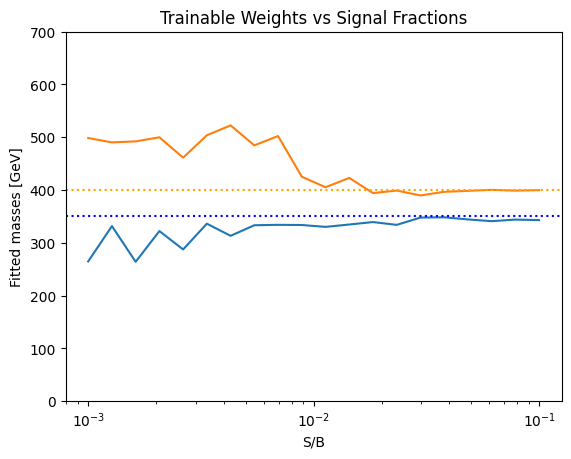

In [900]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

Text(0, 0.5, 'Fitted S/B')

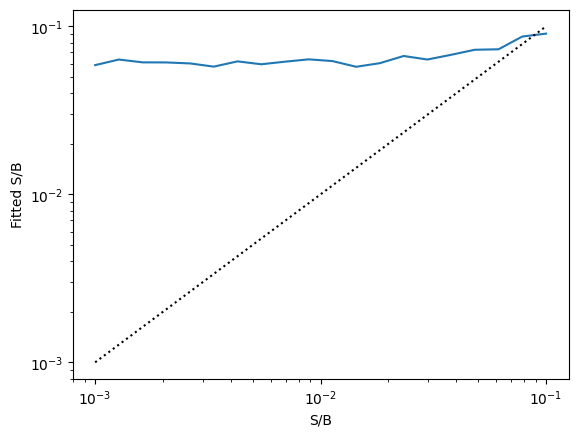

In [902]:
plt.plot(sig_list,np.array(w3_list))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")

Text(0, 0.5, 'max SIC')

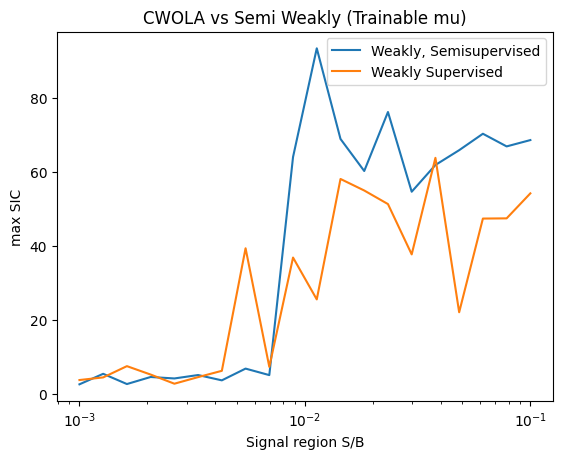

In [904]:
plt.plot(sig_list,max_SIC1,label="Weakly, Semisupervised")
plt.plot(sig_list,max_SIC2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Signal Fraction:  0.001
Epoch 1/20
30/30 [==============================] - 2s 30ms/step - loss: 0.7132 - val_loss: 0.7086
Epoch 2/20
30/30 [==============================] - 0s 6ms/step - loss: 0.7051 - val_loss: 0.7035
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7014 - val_loss: 0.7011
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6995 - val_loss: 0.6996
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6983 - val_loss: 0.6985
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6974 - val_loss: 0.6978
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6968 - val_loss: 0.6972
Epoch 8/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6963 - val_loss: 0.6968
Epoch 9/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6960 - val_loss: 0.6964
Epoch 10/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6956 - val_loss: 0

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 14ms/step - loss: 0.7156 - val_loss: 0.7069
Epoch 2/20
30/30 [==============================] - 1s 30ms/step - loss: 0.7070 - val_loss: 0.7022
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 0.7031 - val_loss: 0.6998
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 0.7009 - val_loss: 0.6984
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6995 - val_loss: 0.6975
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6985 - val_loss: 0.6968
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6977 - val_loss: 0.6963
Epoch 8/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6972 - val_loss: 0.6959
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6967 - val_loss: 0.6956
Epoch 10/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6964 - val_loss: 0.6954
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7147 - val_loss: 0.7077
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7063 - val_loss: 0.7029
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7025 - val_loss: 0.7005
Epoch 4/20
30/30 [==============================] - 1s 31ms/step - loss: 0.7003 - val_loss: 0.6990
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6989 - val_loss: 0.6980
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6980 - val_loss: 0.6974
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6972 - val_loss: 0.6969
Epoch 8/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6967 - val_loss: 0.6965
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6962
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6958
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7123 - val_loss: 0.7094
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7042 - val_loss: 0.7044
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 0.7007 - val_loss: 0.7018
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6988 - val_loss: 0.7002
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6977 - val_loss: 0.6991
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6983
Epoch 7/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6963 - val_loss: 0.6977
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6972
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6969
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6966
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7147 - val_loss: 0.7073
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7063 - val_loss: 0.7025
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7026 - val_loss: 0.7000
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7006 - val_loss: 0.6986
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.6976
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6983 - val_loss: 0.6969
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6976 - val_loss: 0.6964
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6970 - val_loss: 0.6960
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6966 - val_loss: 0.6957
Epoch 10/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6962 - val_loss: 0.6954
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7129 - val_loss: 0.7091
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7047 - val_loss: 0.7041
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 0.7012 - val_loss: 0.7014
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6991 - val_loss: 0.6999
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6988
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6981
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6975
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6971
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6967
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6964
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7132 - val_loss: 0.7083
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7051 - val_loss: 0.7033
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 0.7013 - val_loss: 0.7010
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6993 - val_loss: 0.6995
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6980 - val_loss: 0.6985
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6972 - val_loss: 0.6978
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6966 - val_loss: 0.6972
Epoch 8/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6961 - val_loss: 0.6968
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6958 - val_loss: 0.6964
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6961
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7136 - val_loss: 0.7078
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7055 - val_loss: 0.7028
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7019 - val_loss: 0.7002
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6999 - val_loss: 0.6988
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6986 - val_loss: 0.6977
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6978 - val_loss: 0.6970
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6965
Epoch 8/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6966 - val_loss: 0.6961
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6962 - val_loss: 0.6957
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6955
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7118 - val_loss: 0.7095
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7040 - val_loss: 0.7043
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7006 - val_loss: 0.7016
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6987 - val_loss: 0.7000
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6976 - val_loss: 0.6989
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6967 - val_loss: 0.6982
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6962 - val_loss: 0.6976
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6957 - val_loss: 0.6971
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6967
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6951 - val_loss: 0.6964
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


Epoch 1/20
30/30 [==============================] - 1s 13ms/step - loss: 0.7141 - val_loss: 0.7069
Epoch 2/20
30/30 [==============================] - 0s 6ms/step - loss: 0.7058 - val_loss: 0.7022
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7021 - val_loss: 0.6997
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7000 - val_loss: 0.6984
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6987 - val_loss: 0.6974
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6978 - val_loss: 0.6968
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6963
Epoch 8/20
30/30 [==============================] - 0s 7ms/step - loss: 0.6966 - val_loss: 0.6960
Epoch 9/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6961 - val_loss: 0.6957
Epoch 10/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6957 - val_loss: 0.6955
Epoch 11/20
30/30 

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 20ms/step - loss: 0.7136 - val_loss: 0.7071
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7054 - val_loss: 0.7022
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7018 - val_loss: 0.6997
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6998 - val_loss: 0.6983
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6985 - val_loss: 0.6974
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6976 - val_loss: 0.6967
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6970 - val_loss: 0.6963
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6959
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6957
Epoch 10/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6956 - val_loss: 0.6955
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7137 - val_loss: 0.7063
Epoch 2/20
30/30 [==============================] - 1s 31ms/step - loss: 0.7054 - val_loss: 0.7015
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7017 - val_loss: 0.6992
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6997 - val_loss: 0.6979
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6984 - val_loss: 0.6970
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6975 - val_loss: 0.6963
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6968 - val_loss: 0.6958
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6954
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6951
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6949
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 12ms/step - loss: 0.7128 - val_loss: 0.7067
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7046 - val_loss: 0.7018
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7010 - val_loss: 0.6994
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.6981
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6978 - val_loss: 0.6972
Epoch 6/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6969 - val_loss: 0.6966
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6961 - val_loss: 0.6963
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6960
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6951 - val_loss: 0.6958
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6947 - val_loss: 0.6955
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 12ms/step - loss: 0.7122 - val_loss: 0.7059
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7043 - val_loss: 0.7013
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7006 - val_loss: 0.6991
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6987 - val_loss: 0.6977
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6974 - val_loss: 0.6968
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6966 - val_loss: 0.6962
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6959 - val_loss: 0.6957
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6954
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6951 - val_loss: 0.6952
Epoch 10/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6948 - val_loss: 0.6950
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 12ms/step - loss: 0.7111 - val_loss: 0.7061
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7032 - val_loss: 0.7015
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6998 - val_loss: 0.6991
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6977
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6968 - val_loss: 0.6967
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6960 - val_loss: 0.6961
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6956
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6950 - val_loss: 0.6953
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6947 - val_loss: 0.6950
Epoch 10/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6945 - val_loss: 0.6947
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 13ms/step - loss: 0.7122 - val_loss: 0.7036
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7040 - val_loss: 0.6992
Epoch 3/20
31/31 [==============================] - 0s 6ms/step - loss: 0.7003 - val_loss: 0.6970
Epoch 4/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6984 - val_loss: 0.6958
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6972 - val_loss: 0.6950
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6944
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6941
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6938
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6951 - val_loss: 0.6936
Epoch 10/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6948 - val_loss: 0.6934
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 12ms/step - loss: 0.7090 - val_loss: 0.7050
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7015 - val_loss: 0.7003
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6983 - val_loss: 0.6979
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6966 - val_loss: 0.6966
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6957
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6949 - val_loss: 0.6951
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6945 - val_loss: 0.6947
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6941 - val_loss: 0.6943
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6938 - val_loss: 0.6941
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6936 - val_loss: 0.6939
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 12ms/step - loss: 0.7090 - val_loss: 0.7033
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7013 - val_loss: 0.6988
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6980 - val_loss: 0.6965
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6953
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6945
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6946 - val_loss: 0.6940
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6941 - val_loss: 0.6936
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6937 - val_loss: 0.6933
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6935 - val_loss: 0.6931
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6933 - val_loss: 0.6929
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 12ms/step - loss: 0.7084 - val_loss: 0.7014
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7007 - val_loss: 0.6969
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6974 - val_loss: 0.6950
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6958 - val_loss: 0.6938
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6948 - val_loss: 0.6931
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6941 - val_loss: 0.6927
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6937 - val_loss: 0.6923
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6933 - val_loss: 0.6920
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6919
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6929 - val_loss: 0.6918
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 11ms/step - loss: 0.7048 - val_loss: 0.7011
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6977 - val_loss: 0.6967
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6948 - val_loss: 0.6947
Epoch 4/20
31/31 [==============================] - 1s 28ms/step - loss: 0.6934 - val_loss: 0.6935
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6925 - val_loss: 0.6929
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6920 - val_loss: 0.6924
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6916 - val_loss: 0.6921
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6914 - val_loss: 0.6920
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6911 - val_loss: 0.6918
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6910 - val_loss: 0.6917
Epoch 11/20
31/31 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


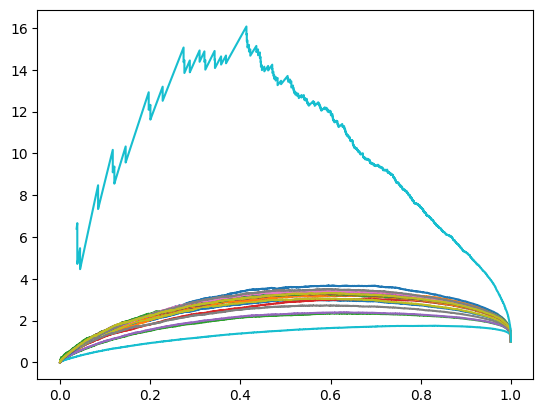

In [940]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_qq.layers:
        l.trainable=False

    model3 = createSimpleModel(2)
    model32 = createSimpleModel(5)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(6,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    #LLR_xs = 1 +sigfrac*LLR - sigfrac
    LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3.5
    m2 = 5.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2))
    
    max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#    max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

(0.0, 700.0)

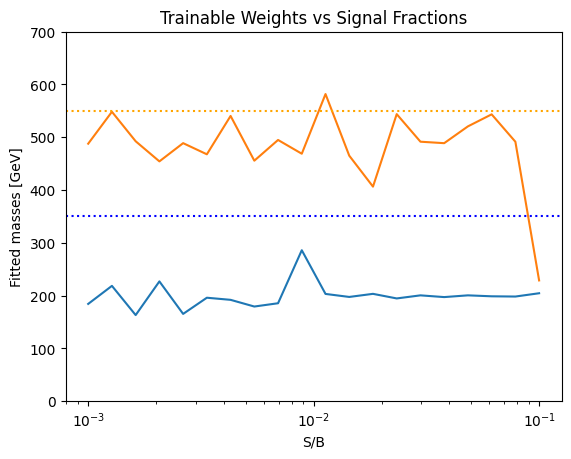

In [941]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

Text(0, 0.5, 'Fitted S/B')

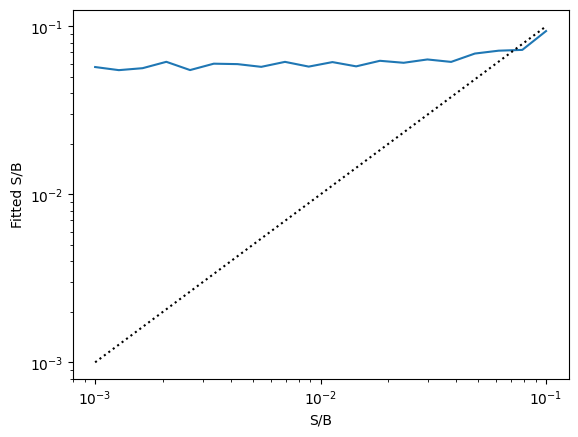

In [942]:
plt.plot(sig_list,np.array(w3_list))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")
plt.title("S/B vs Fitted S/B")

Text(0.5, 1.0, 'Significance Improvement vs S/B')

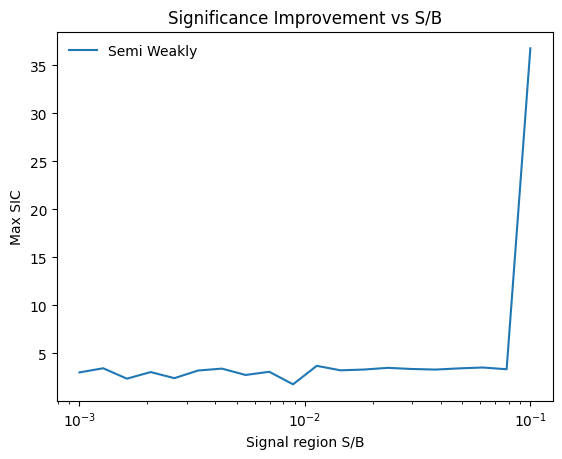

In [943]:
plt.plot(sig_list,max_SIC1,label="Semi Weakly")
#plt.plot(sig_list,max_SIC2,label="Weakly (CWOLA)")
plt.legend(frameon = False)
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")
plt.title("Significance Improvement vs S/B")
#plt.axhline(450,ls=":",color='orange')
#plt.axhline(200,ls=":",color='blue')
#plt.ylim([0,2])

Signal Fraction:  0.001
Epoch 1/20
30/30 [==============================] - 1s 10ms/step - loss: 0.7152 - val_loss: 0.7074
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7066 - val_loss: 0.7026
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7026 - val_loss: 0.7003
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7004 - val_loss: 0.6989
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.6979
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6980 - val_loss: 0.6971
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6972 - val_loss: 0.6966
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6967 - val_loss: 0.6962
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6958
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 13ms/step - loss: 0.7125 - val_loss: 0.7093
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7046 - val_loss: 0.7041
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7011 - val_loss: 0.7016
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.7000
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6980 - val_loss: 0.6989
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6972 - val_loss: 0.6982
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6965 - val_loss: 0.6975
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6961 - val_loss: 0.6971
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6957 - val_loss: 0.6967
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6964
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7138 - val_loss: 0.7082
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7057 - val_loss: 0.7032
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7021 - val_loss: 0.7007
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7000 - val_loss: 0.6992
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6988 - val_loss: 0.6981
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6974
Epoch 7/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6972 - val_loss: 0.6968
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6967 - val_loss: 0.6964
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6961
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6958
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7124 - val_loss: 0.7094
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7045 - val_loss: 0.7043
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7009 - val_loss: 0.7019
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6989 - val_loss: 0.7004
Epoch 5/20
30/30 [==============================] - 0s 11ms/step - loss: 0.6977 - val_loss: 0.6993
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6985
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6979
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6958 - val_loss: 0.6974
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6970
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6967
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7139 - val_loss: 0.7081
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7056 - val_loss: 0.7033
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7019 - val_loss: 0.7007
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6999 - val_loss: 0.6992
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6986 - val_loss: 0.6982
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6977 - val_loss: 0.6975
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6970 - val_loss: 0.6969
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6965 - val_loss: 0.6965
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6961 - val_loss: 0.6962
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6957 - val_loss: 0.6959
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7126 - val_loss: 0.7096
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7047 - val_loss: 0.7043
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7012 - val_loss: 0.7016
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.7000
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6990
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6983
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6978
Epoch 8/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6959 - val_loss: 0.6973
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6971
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6968
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7137 - val_loss: 0.7080
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7054 - val_loss: 0.7030
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7018 - val_loss: 0.7005
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6997 - val_loss: 0.6990
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6985 - val_loss: 0.6980
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6976 - val_loss: 0.6973
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6967
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6963
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6960
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6957 - val_loss: 0.6957
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7154 - val_loss: 0.7062
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7069 - val_loss: 0.7016
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7030 - val_loss: 0.6992
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7008 - val_loss: 0.6979
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6994 - val_loss: 0.6970
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6984 - val_loss: 0.6964
Epoch 7/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6977 - val_loss: 0.6959
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6956
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6966 - val_loss: 0.6953
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6950
Epoch 11/20
30/30 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7122 - val_loss: 0.7088
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7042 - val_loss: 0.7037
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7008 - val_loss: 0.7012
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6989 - val_loss: 0.6996
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6977 - val_loss: 0.6986
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6978
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6973
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6968
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.6964
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6962
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7125 - val_loss: 0.7084
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7045 - val_loss: 0.7034
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7010 - val_loss: 0.7009
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.6994
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.6984
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6970 - val_loss: 0.6977
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6971
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6966
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6963
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6960
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 11ms/step - loss: 0.7111 - val_loss: 0.7093
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7035 - val_loss: 0.7040
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7002 - val_loss: 0.7013
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6984 - val_loss: 0.6997
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6973 - val_loss: 0.6986
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6966 - val_loss: 0.6978
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6972
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6968
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6964
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6951 - val_loss: 0.6960
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.7103 - val_loss: 0.7096
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7028 - val_loss: 0.7043
Epoch 3/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6997 - val_loss: 0.7016
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6979 - val_loss: 0.7000
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6989
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6962 - val_loss: 0.6981
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6975
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6970
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6949 - val_loss: 0.6966
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6946 - val_loss: 0.6963
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 10ms/step - loss: 0.7128 - val_loss: 0.7066
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7045 - val_loss: 0.7019
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7010 - val_loss: 0.6994
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.6980
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6978 - val_loss: 0.6971
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6964
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6959
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6958 - val_loss: 0.6955
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6952
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6951 - val_loss: 0.6950
Epoch 11/20
30/30 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.7129 - val_loss: 0.7061
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7048 - val_loss: 0.7012
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7012 - val_loss: 0.6988
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.6973
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6980 - val_loss: 0.6964
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6957
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6965 - val_loss: 0.6953
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6949
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6956 - val_loss: 0.6946
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6953 - val_loss: 0.6944
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30/30 [==============================] - 1s 9ms/step - loss: 0.7096 - val_loss: 0.7075
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.7022 - val_loss: 0.7025
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6989 - val_loss: 0.7001
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6971 - val_loss: 0.6986
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6960 - val_loss: 0.6977
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6953 - val_loss: 0.6969
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6948 - val_loss: 0.6964
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6944 - val_loss: 0.6960
Epoch 9/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6941 - val_loss: 0.6957
Epoch 10/20
30/30 [==============================] - 0s 5ms/step - loss: 0.6939 - val_loss: 0.6955
Epoch 11/20
30/30 [===========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 7s 213ms/step - loss: 0.7096 - val_loss: 0.7064
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7020 - val_loss: 0.7015
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6987 - val_loss: 0.6991
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6969 - val_loss: 0.6976
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6959 - val_loss: 0.6968
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6961
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6947 - val_loss: 0.6956
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6943 - val_loss: 0.6952
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6940 - val_loss: 0.6949
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6938 - val_loss: 0.6947
Epoch 11/20
31/31 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 12ms/step - loss: 0.7092 - val_loss: 0.7050
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7014 - val_loss: 0.7004
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6981 - val_loss: 0.6982
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6963 - val_loss: 0.6969
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6952 - val_loss: 0.6961
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6945 - val_loss: 0.6955
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6940 - val_loss: 0.6950
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6936 - val_loss: 0.6947
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6945
Epoch 10/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6943
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 13ms/step - loss: 0.7091 - val_loss: 0.7034
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.7014 - val_loss: 0.6987
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6981 - val_loss: 0.6966
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6964 - val_loss: 0.6953
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6954 - val_loss: 0.6945
Epoch 6/20
31/31 [==============================] - 1s 28ms/step - loss: 0.6947 - val_loss: 0.6939
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6942 - val_loss: 0.6935
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6939 - val_loss: 0.6932
Epoch 9/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6936 - val_loss: 0.6930
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6928
Epoch 11/20
31/31 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 13ms/step - loss: 0.7075 - val_loss: 0.7020
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6999 - val_loss: 0.6976
Epoch 3/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6967 - val_loss: 0.6956
Epoch 4/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6951 - val_loss: 0.6945
Epoch 5/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6941 - val_loss: 0.6938
Epoch 6/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6935 - val_loss: 0.6933
Epoch 7/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6929
Epoch 8/20
31/31 [==============================] - 1s 29ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 9/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 10/20
31/31 [==============================] - 0s 6ms/step - loss: 0.6923 - val_loss: 0.6924
Epoch 11/20
31/31 [=========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


31/31 [==============================] - 1s 11ms/step - loss: 0.7049 - val_loss: 0.7009
Epoch 2/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6976 - val_loss: 0.6966
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6946 - val_loss: 0.6947
Epoch 4/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6932 - val_loss: 0.6936
Epoch 5/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6923 - val_loss: 0.6929
Epoch 6/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6918 - val_loss: 0.6924
Epoch 7/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6914 - val_loss: 0.6921
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6912 - val_loss: 0.6919
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6910 - val_loss: 0.6917
Epoch 10/20
31/31 [==============================] - 0s 5ms/step - loss: 0.6908 - val_loss: 0.6916
Epoch 11/20
31/31 [==========

/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2033172/3689160371.py:75: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


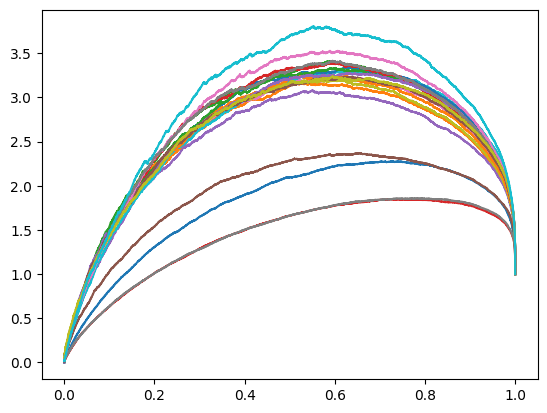

In [946]:
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_qq.layers:
        l.trainable=False

    model3 = createSimpleModel(2)
    model32 = createSimpleModel(5)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(6,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    #LLR_xs = 1 +sigfrac*LLR - sigfrac
    LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3.5
    m2 = 5.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

    scores = model_all2.predict(np.concatenate([x[0,0][0:train_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(train_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    #CWOLA
#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=4, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)
    
#     scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2))
    
    max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
#    max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

(0.0, 700.0)

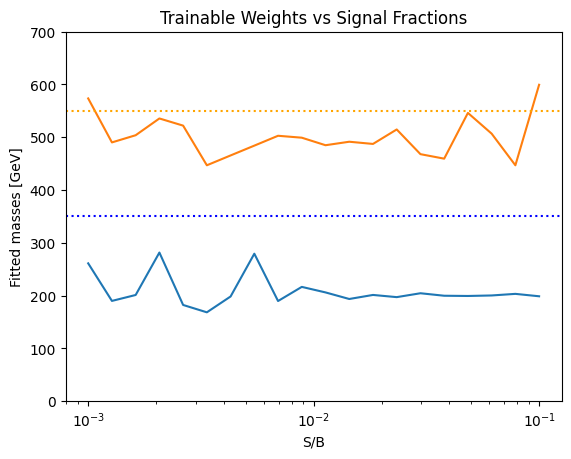

In [948]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

Text(0.5, 1.0, 'S/B vs Fitted S/B')

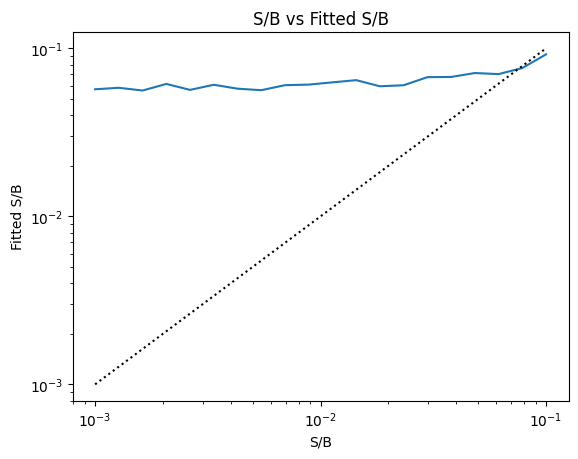

In [950]:
plt.plot(sig_list,np.array(w3_list))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")
plt.title("S/B vs Fitted S/B")